# 1. Introduction

This project aims to develop a set of predictive model for monitoring and optimizing water quality in freshwater aquaponics systems dedicated to catfish farming. By leveraging IoT sensor data and machine learning techniques, we analyze key environmental and biological factors influencing water health and fish well-being. Our system integrates real-time data collection from twelve aquaponics ponds, each monitored by an ESP-32 microcontroller equipped with sensors measuring parameters such as turbidity, temperature, ammonia, nitrate, dissolved oxygen, and pH.

The *Sensor Based Aquaponics Fish Pond Datasets*$\text{}^{1}$ consists of time-series records spanning from June to mid-October 2021, collected from twelve aquaponics ponds. Each pond is monitored individually, with IoT units capturing data every five minutes. These measurements provide insights into the complex interactions between water conditions and fish health, enabling predictive analytics for early issue detection and improved aquaponics management.

Key Variables in the Dataset:

- **Date/Time:** Timestamp of the recorded data.
- **Temperature:** Water temperature in degrees Celsius.
- **Turbidity:** Cloudiness or haziness of the water due to suspended particles.
- **Dissolved Oxygen (DO):** Oxygen available in water, essential for fish respiration and aerobic microbial processes.
- **pH:** Acidity or alkalinity of the water, crucial for maintaining optimal conditions.
- **Ammonia:** Concentration of ammonia, a byproduct of fish waste and organic matter decomposition.
- **Nitrate:** End-product of the nitrification process, impacting plant and microbial interactions.
- **Fish Population:** Number of fish in the pond at the time of measurement.
- **Fish Length:** Length of individual fish, indicating growth trends.
- **Fish Weight:** Mass of individual fish, reflecting health and development.

# 2. Library Imports and Functions

In [5]:
# import necessary libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import DomainWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam




import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings('ignore', category=FutureWarning, module='statsmodels.genmod.families.links')
warnings.filterwarnings("ignore", category=DomainWarning)

# 3. Data Loading and Initial Overview

In [7]:
# load IoT dataset
pond1_raw = pd.read_csv('data/archive/IoTPond1.csv')
pond1_raw.head()

,created_at,entry_id,Temperature (C),Turbidity(NTU),Dissolved Oxygen(g/ml),PH,Ammonia(g/ml),Nitrate(g/ml),Population,Fish_Length(cm),Fish_Weight(g)
0,2021-06-19 00:00:05 CET,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
1,2021-06-19 00:01:02 CET,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2,2021-06-19 00:01:22 CET,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
3,2021-06-19 00:01:44 CET,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
4,2021-06-19 00:02:07 CET,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


In [8]:
# get shape of data set, data types and non-null count
pond1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83126 entries, 0 to 83125
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              83126 non-null  object 
 1   entry_id                83126 non-null  int64  
 2   Temperature (C)         83126 non-null  float64
 3   Turbidity(NTU)          83126 non-null  int64  
 4   Dissolved Oxygen(g/ml)  83126 non-null  float64
 5   PH                      83126 non-null  float64
 6   Ammonia(g/ml)           83074 non-null  float64
 7   Nitrate(g/ml)           83126 non-null  int64  
 8   Population              83126 non-null  int64  
 9   Fish_Length(cm)         83124 non-null  float64
 10  Fish_Weight(g)          83124 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.0+ MB


# 4. Data Cleaning

In [10]:
# create a deep copy of the raw data
pond1 = pond1_raw.copy()

### Validate reading timestamp

In [12]:
# convert 'created_at' to datetime format
pond1['created_at'] = pd.to_datetime(pond1['created_at'], 
                                     errors='coerce') # if invalid date, replace with `NaT`
# check for invalid dates
print(f"Rows with invalid dates: { pond1['created_at'].isna().sum() }")

Rows with invalid dates: 0


### Modify columns names

In [14]:
# rename columns for easy reference
pond1.rename(columns={
    'created_at': 'datetime',
    'Temperature (C)': 'temperature',
    'Turbidity(NTU)': 'turbidity',
    'Dissolved Oxygen(g/ml)': 'dissolved_oxygen',
    'PH':'ph',
    'Ammonia(g/ml)': 'ammonia',
    'Nitrate(g/ml)': 'nitrate',
    'Population': 'population',
    'Fish_Length(cm)': 'fish_length',
    'Fish_Weight(g)': 'fish_weight'
}, inplace=True)

# set 'datetime' as the index for time-series analysis
# pond1.set_index('datetime', inplace=True)

print(f"Renamed columns: { pond1.columns.tolist() }")

Renamed columns: ['datetime', 'entry_id', 'temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'nitrate', 'population', 'fish_length', 'fish_weight']


### Check for missing data

In [16]:
# replace missing values with column-wise mean
pond1.fillna(pond1.mean(), inplace=True)
print("Missing values replaced by column-wise mean")

# # remove missing values 
# n_before = pond1.shape[0] # number of rows before dropping NaN values
# pond1.dropna(inplace=True) # drop missing values
# n_after = pond1.shape[0] # Get the number of rows after dropping NaN values

# print(f"Number of rows deleted: {n_before - n_after}")

pond1.info()

Missing values replaced by column-wise mean
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83126 entries, 0 to 83125
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          83126 non-null  datetime64[ns]
 1   entry_id          83126 non-null  int64         
 2   temperature       83126 non-null  float64       
 3   turbidity         83126 non-null  int64         
 4   dissolved_oxygen  83126 non-null  float64       
 5   ph                83126 non-null  float64       
 6   ammonia           83126 non-null  float64       
 7   nitrate           83126 non-null  int64         
 8   population        83126 non-null  int64         
 9   fish_length       83126 non-null  float64       
 10  fish_weight       83126 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 7.0 MB


### Cleaned dataset

In [18]:
pond1.head()

,datetime,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
0,2021-06-19 00:00:05,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
1,2021-06-19 00:01:02,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2,2021-06-19 00:01:22,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
3,2021-06-19 00:01:44,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
4,2021-06-19 00:02:07,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


# 5. Exploratory Data Analysis (EDA)

### Summary statistics for numerical columns

In [21]:
pond1.describe()

,datetime,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
count,83126,83126.000000,83126.000000,83126.000000,83126.000000,83126.000000,8.312600e+04,83126.000000,83126.0,83126.000000,83126.000000
mean,2021-07-21 16:09:26.662151424,84018.144516,24.573376,87.490160,12.390251,7.518329,2.030817e+08,458.294408,50.0,16.414686,44.568470
min,2021-06-19 00:00:05,1889.000000,-127.000000,1.000000,0.007000,-0.586270,6.770000e-03,45.000000,50.0,7.110000,2.910000
25%,2021-07-01 01:54:57.750000128,24902.250000,24.125000,91.000000,3.440000,7.153520,4.584200e-01,146.000000,50.0,11.790000,14.190000
50%,2021-07-27 17:36:44,103478.500000,24.562500,100.000000,7.133000,7.357790,6.139700e-01,347.000000,50.0,18.080000,54.700000
75%,2021-08-08 13:36:09,131074.750000,24.937500,100.000000,15.819000,7.838980,1.565161e+01,823.000000,50.0,21.000000,67.520000
max,2021-10-13 04:14:22,247405.000000,27.750000,100.000000,41.046000,8.551670,4.270000e+11,1936.000000,50.0,33.450000,318.640000
std,NaN,53579.484245,0.861532,25.859375,12.518253,0.534787,7.863770e+09,338.313206,0.0,5.272180,33.215091


### Data Dristribution and Trends

#### Histrograms: Describes how values in the dataset are spread across a range.

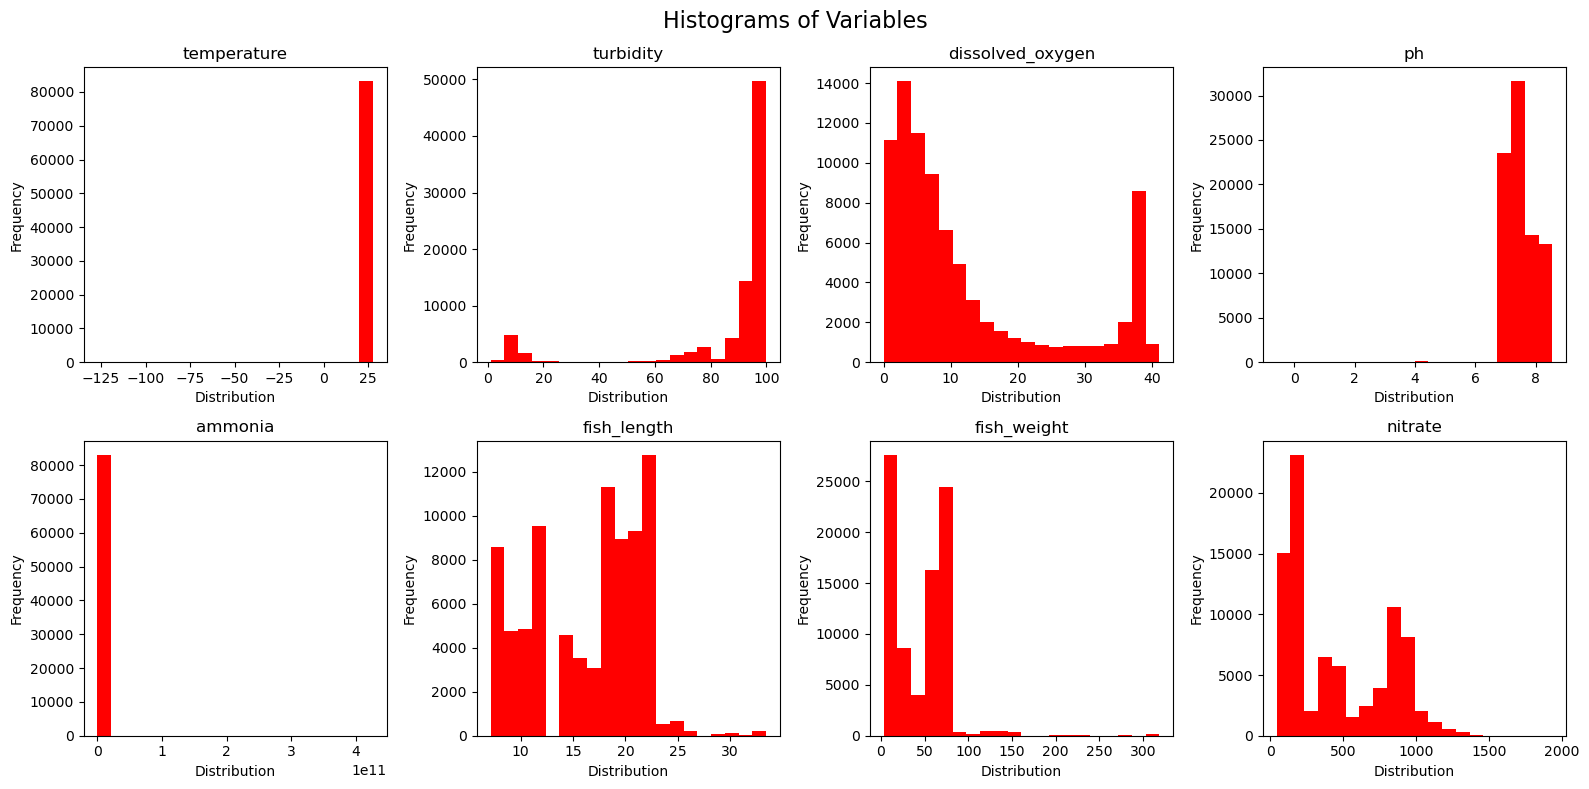

In [24]:
# without population since its a contant value
vars = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'fish_length', 'fish_weight','nitrate']

# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1[col], bins=20, color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel("Distribution")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

#### Visual Representation: Shows patterns of change in the dataset over time.

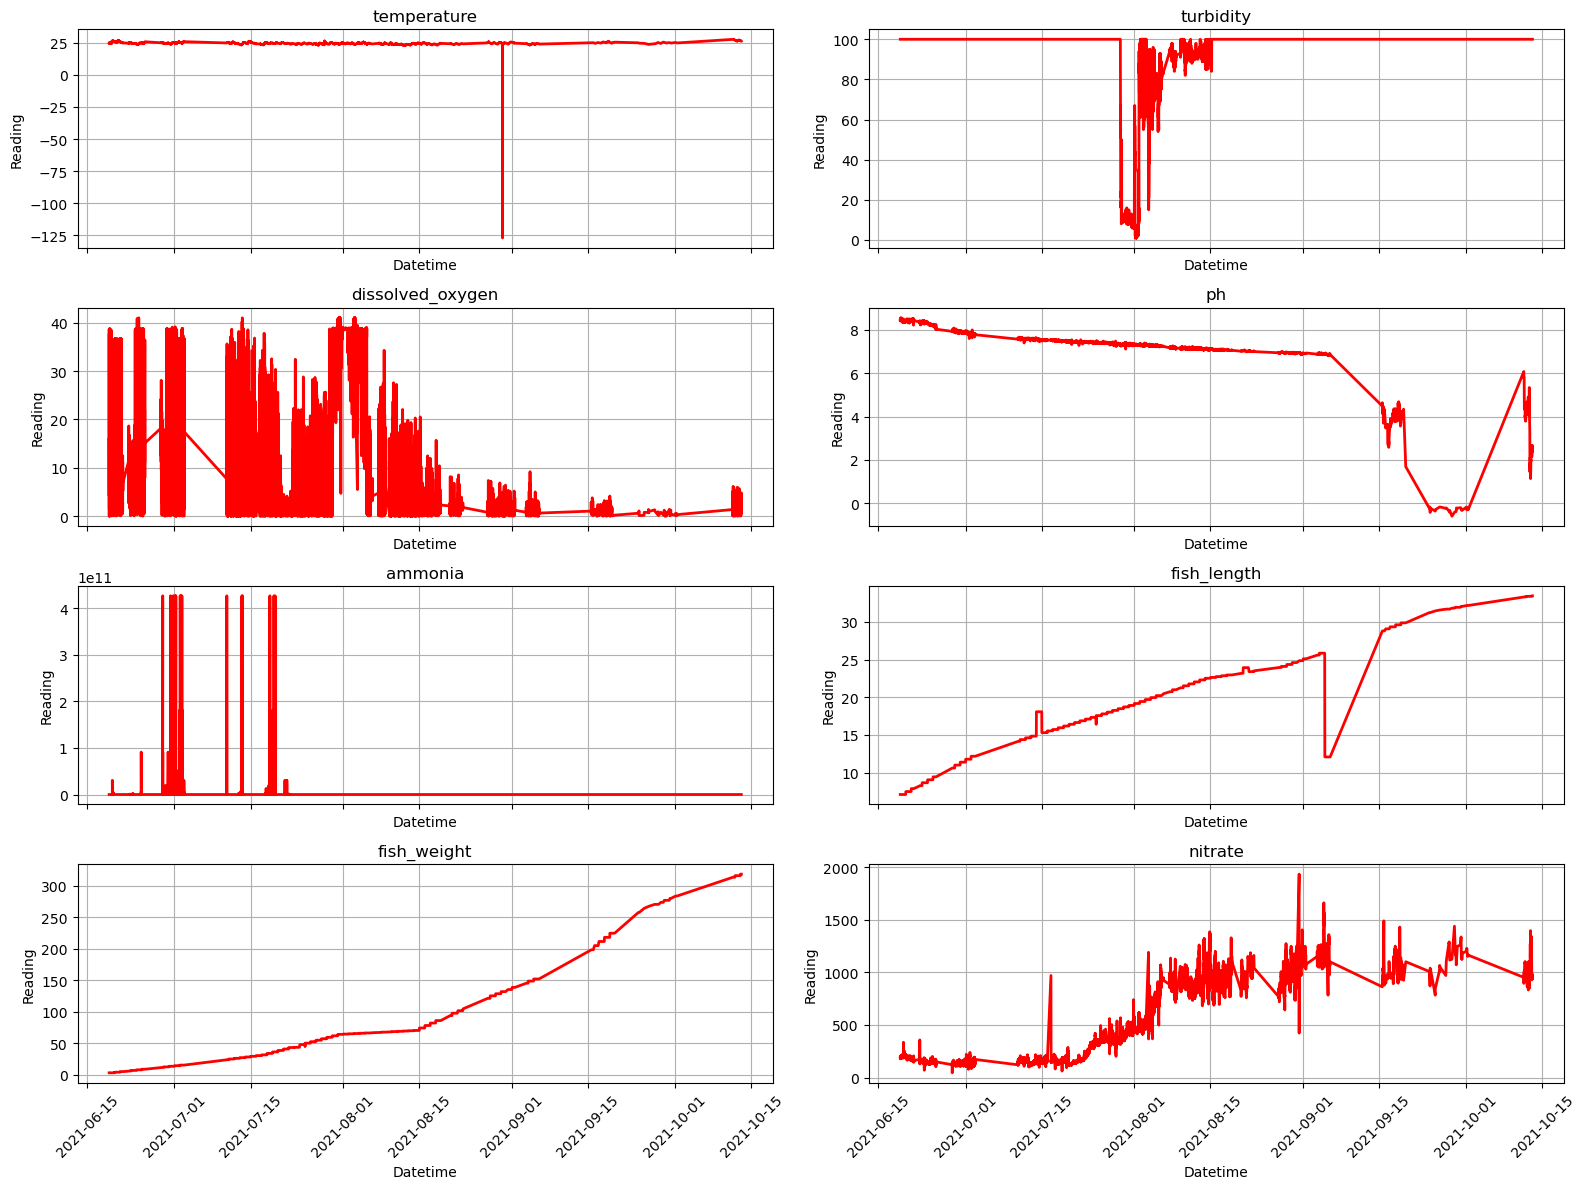

In [26]:
# set grid size and share x-axis
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)

# flatten axes for easy iteration
axes = axes.flatten()

# create subplots for each variable using 'datetime' as the x-axis
for i, col in enumerate(vars):
    axes[i].plot(pond1['datetime'], pond1[col], linewidth=2, color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel("Datetime")  # x-axis label
    axes[i].set_ylabel("Reading")  # y-axis label
    axes[i].grid(True)  # add grid 
    axes[i].tick_params(axis='x', rotation=45) # tilt for better readability

# ddjust layout
plt.tight_layout()
plt.show()

### Handling outliers and timestamps gaps

#### Outliers: Replace outliers by interpolating between known values

In [29]:
# calculate quartiles
Q1 = pond1.quantile(0.25, axis=0)  # 25th percentile
Q3 = pond1.quantile(0.75, axis=0)  # 75th percentile
IQR = Q3 - Q1  # interquartile range

# define the outlier upper/lower bounds
t = 1.5 # thresholds
lower_bound = Q1 - t * IQR
upper_bound = Q3 + t * IQR

# identify outliers
outliers = (pond1 < lower_bound) | (pond1 > upper_bound)

# replace outliers with the previous valid value in each column
pond1_cleaned = pond1.copy()
pond1_cleaned[outliers] = np.nan  # temporarily set outliers as NaN
pond1_cleaned.interpolate(method='linear', inplace=True) # estimates missing values by interpolating between known values

pond1_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83126 entries, 0 to 83125
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          83126 non-null  datetime64[ns]
 1   entry_id          83126 non-null  int64         
 2   temperature       83126 non-null  float64       
 3   turbidity         83126 non-null  float64       
 4   dissolved_oxygen  83126 non-null  float64       
 5   ph                83126 non-null  float64       
 6   ammonia           83126 non-null  float64       
 7   nitrate           83126 non-null  float64       
 8   population        83126 non-null  int64         
 9   fish_length       83126 non-null  float64       
 10  fish_weight       83126 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 7.0 MB


#### Timestamp Gaps: Fix Missing Timestamps with 1 Minute Interval Interpolation

In [31]:
# creates a df with uniform intervals of 1 minute frequency
time_range = pd.DataFrame({'datetime': pd.date_range(start=pond1_cleaned['datetime'].min(), 
                                                          end=pond1_cleaned['datetime'].max(), 
                                                          freq='1T')})  # 1 minute intervals

pond1_fixed = pd.merge(time_range, pond1_cleaned, on='datetime', how='left') # merge with the original pond1 dataset
pond1_fixed.interpolate(method='linear', inplace=True)  # fill NaN values with interpolation 

#### Histrograms: After further cleaning

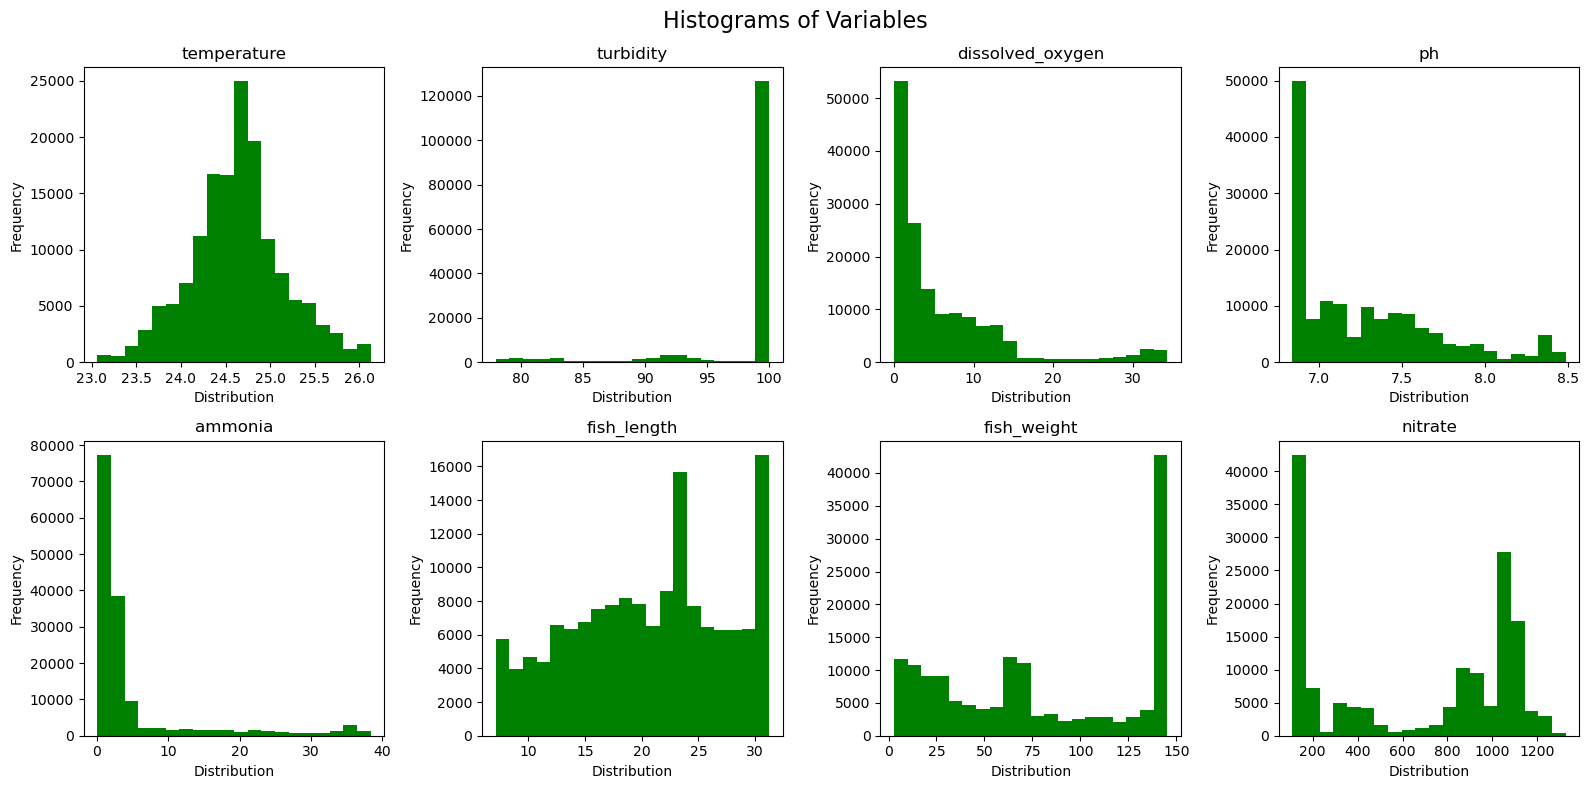

In [33]:
# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1_fixed[col], bins=20,  color='green')
    axes[i].set_title(col)
    axes[i].set_xlabel("Distribution")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

#### Visual Representation: After further cleaning

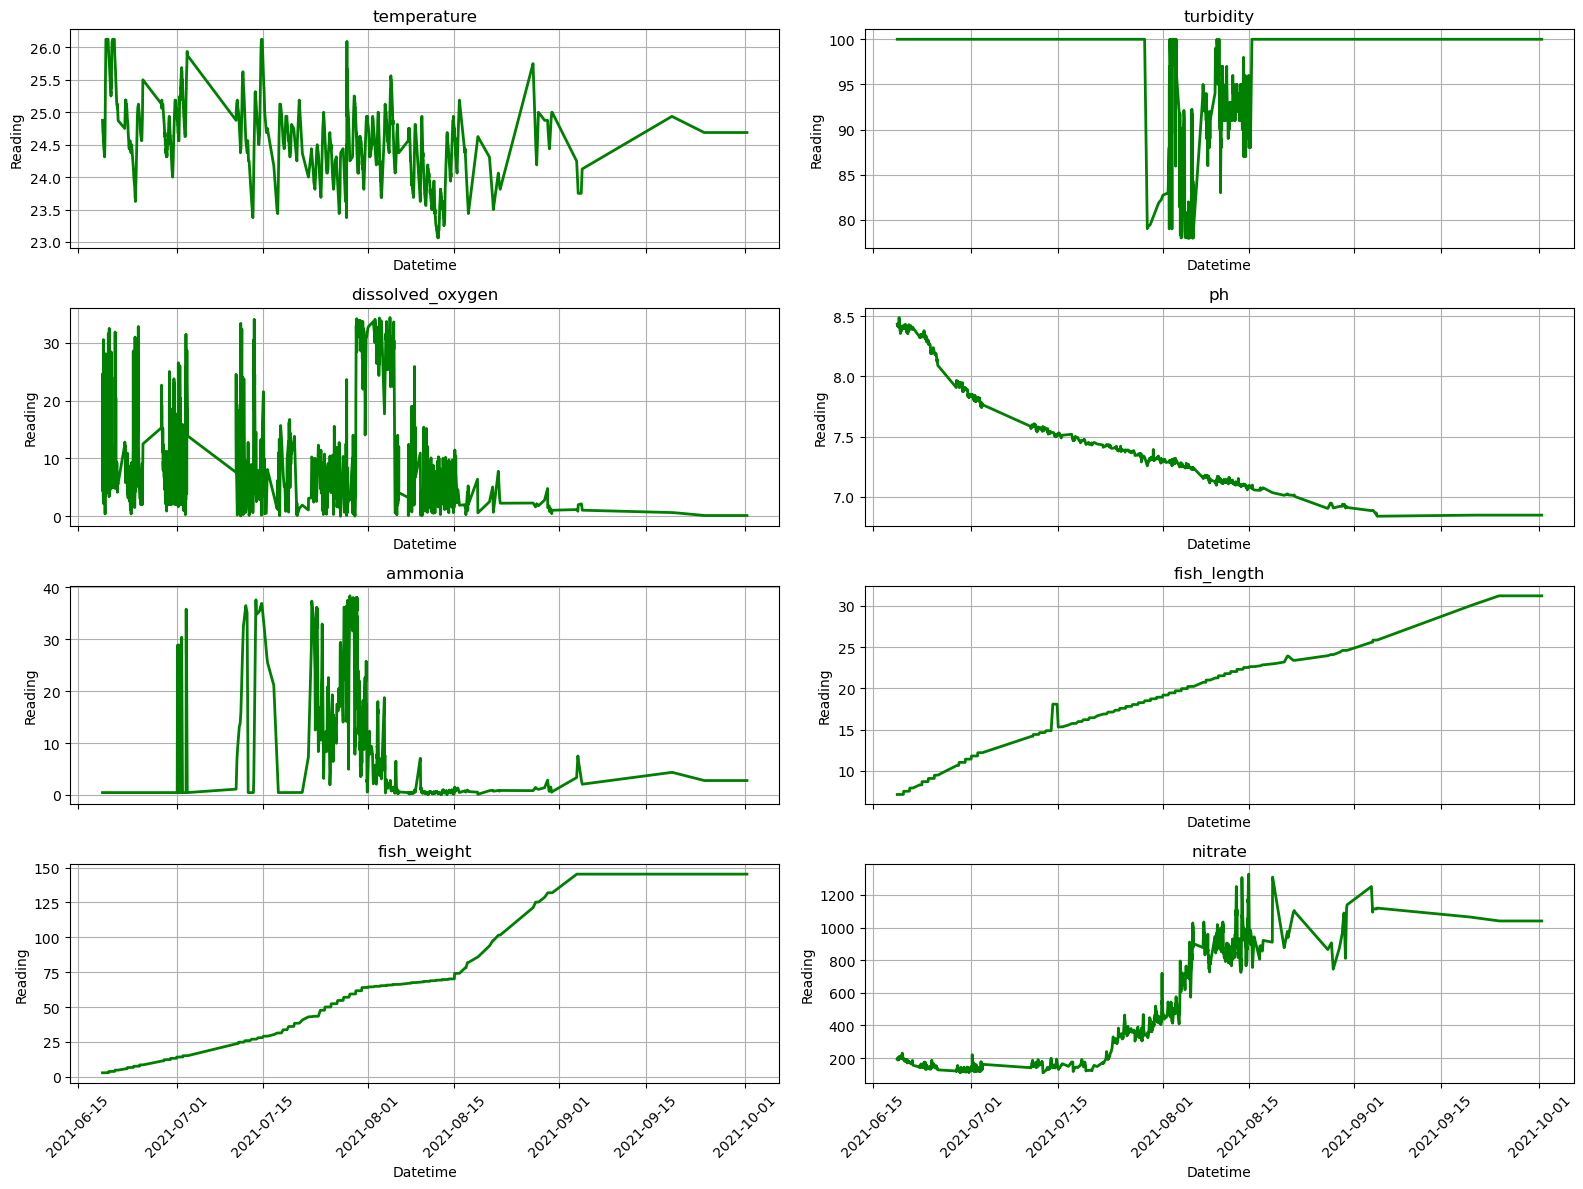

In [35]:
# set grid size and share x-axis
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)

# flatten axes for easy iteration
axes = axes.flatten()

# create subplots for each variable using 'datetime' as the x-axis
for i, col in enumerate(vars):
    axes[i].plot(pond1_fixed['datetime'], pond1_fixed[col], linewidth=2, color='green')
    axes[i].set_title(col)
    axes[i].set_xlabel("Datetime")  # x-axis label
    axes[i].set_ylabel("Reading")  # y-axis label
    axes[i].grid(True)  # add grid 
    axes[i].tick_params(axis='x', rotation=45) # tilt for better readability

# ddjust layout
plt.tight_layout()
plt.show()

### Resampled dataset

In [37]:
pond1_fixed.head()

,datetime,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
0,2021-06-19 00:00:05,1889.000000,24.875000,100.0,4.505000,8.433650,0.45842,193.000000,50.0,7.11,2.91
1,2021-06-19 00:01:05,1891.870130,24.872565,100.0,4.511143,8.433473,0.45842,193.038961,50.0,7.11,2.91
2,2021-06-19 00:02:05,1894.740260,24.870130,100.0,4.517286,8.433296,0.45842,193.077922,50.0,7.11,2.91
3,2021-06-19 00:03:05,1897.610390,24.867695,100.0,4.523429,8.433119,0.45842,193.116883,50.0,7.11,2.91
4,2021-06-19 00:04:05,1900.480519,24.865260,100.0,4.529571,8.432942,0.45842,193.155844,50.0,7.11,2.91


### Data Correlation

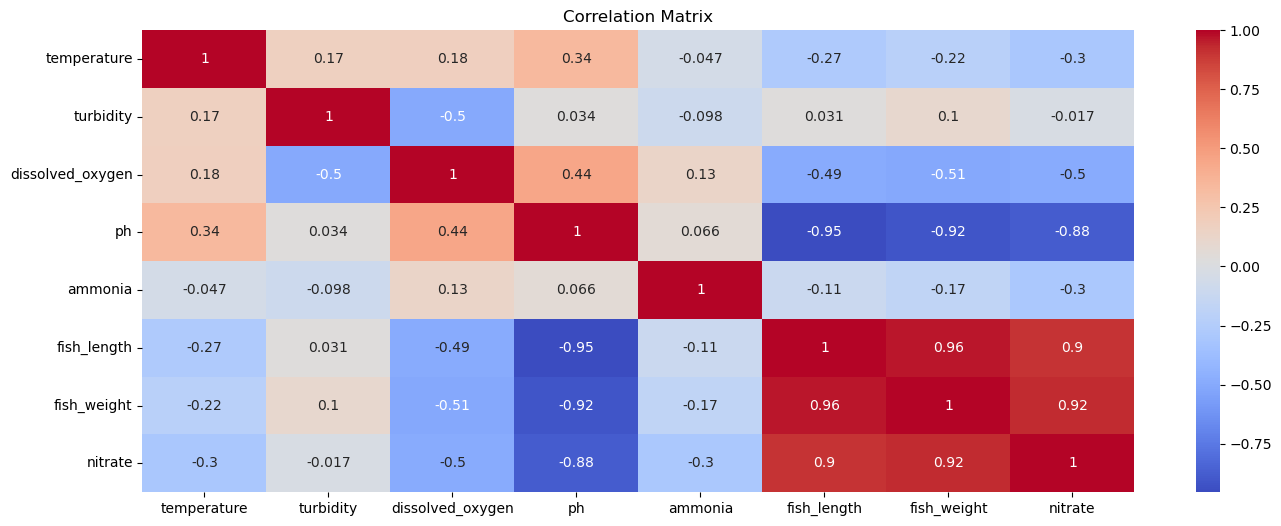

In [39]:
# compute correlation matrix
corr_matrix = pond1_fixed[vars].corr()

# display heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Machine Learning Models

## Traditional

## Deep Learning

#### Feature Selection

In [44]:
# define input features and target
features = ['ph', 'ammonia']  
target = 'temperature'

#### Prepare training data sequence with a predictive horizon

In [47]:
# define sequence length and predictive horizon
seq_length = 30  # 30 min input sequence
ph = 5  # predict 5 minutes ahead

# get numerical values for features and target
data_values = pond1_fixed[features].values 
target_values = pond1_fixed[target].values 

# create sequences
seq_arrays, seq_labs = [], []
for i in range(len(data_values) - seq_length - ph): 
    seq = data_values[i : i + seq_length]  # 30-minute sequence of 'ph' and 'ammonia'
    label = target_values[i + seq_length + ph - 1]  # Target temperature value (5 minutes ahead)
    seq_arrays.append(seq) 
    seq_labs.append(label)

# convert to NumPy arrays
seq_arrays = np.array(seq_arrays, dtype=np.float32)  
seq_labs = np.array(seq_labs, dtype=np.float32)

print(f"Input Shape: {seq_arrays.shape}") 
print(f"Labels Shape: {seq_labs.shape}") 

Input Shape: (150263, 30, 2)
Labels Shape: (150263,)


#### Train-Test Split

In [50]:
# 80/20 train-test split 
train_size = int(len(seq_arrays) * 0.8)  
X_train, X_test = seq_arrays[:train_size], seq_arrays[train_size:]
y_train, y_test = seq_labs[:train_size], seq_labs[train_size:]

print(f"Train Shape: {X_train.shape}, {y_train.shape}")  
print(f"Test Shape: {X_test.shape}, {y_test.shape}")

Train Shape: (120210, 30, 2), (120210,)
Test Shape: (30053, 30, 2), (30053,)


#### LSTM Model Training

In [53]:
# define model parameters
nb_features = len(features)  # input features
nb_out = 1  # only temperature

# build LSTM model
model = Sequential()

model.add(LSTM( # 1st LSTM layer
         input_shape=(seq_length, nb_features),  
         units=50,  
         return_sequences=True))  
model.add(Dropout(0.2))  

model.add(LSTM( # 2nd and last LSTM layer
         units=50,  
         return_sequences=False))  
model.add(Dropout(0.2))  

model.add(Dense(units=nb_out))  # output 
model.add(Activation('linear'))  # regression task

optimizer = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse']) # compile

print(model.summary())

# train 
history = model.fit(
    X_train, y_train, # input sequences and target
    epochs=100, # train for up to 100 epochs
    batch_size=500, # 500 samples per training step
    validation_split=0.05, # 5% of the training data for validation
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping( # stop training early if no improvement
            monitor='val_loss',  
            min_delta=0,  
            patience=10,  
            mode='min',  
            verbose=0)])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
229/229 - 16s - 70ms/step - loss: 25.5192 - mse: 25.5192 - val_loss: 0.0509 - val_mse: 0.0509
Epoch 2/100
229/229 - 16s - 72ms/step - loss: 3.4701 - mse: 3.4701 - val_loss: 0.0399 - val_mse: 0.0399
Epoch 3/100
229/229 - 16s - 71ms/step - loss: 3.4122 - mse: 3.4122 - val_loss: 0.0455 - val_mse: 0.0455
Epoch 4/100
229/229 - 17s - 76ms/step - loss: 3.3751 - mse: 3.3751 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 5/100
229/229 - 17s - 75ms/step - loss: 3.2900 - mse: 3.2900 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 6/100
229/229 - 16s - 71ms/step - loss: 3.2336 - mse: 3.2336 - val_loss: 0.0557 - val_mse: 0.0557
Epoch 7/100
229/229 - 19s - 81ms/step - loss: 3.2030 - mse: 3.2030 - val_loss: 0.0732 - val_mse: 0.0732
Epoch 8/100
229/229 - 19s - 83ms/step - loss: 3.1628 - mse: 3.1628 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 9/100
229/229 - 20s - 87ms/step - loss: 3.0916 - mse: 3.0916 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 10/100
229/229 - 20s - 89ms/step - loss: 2.9949 - m

#### Model History

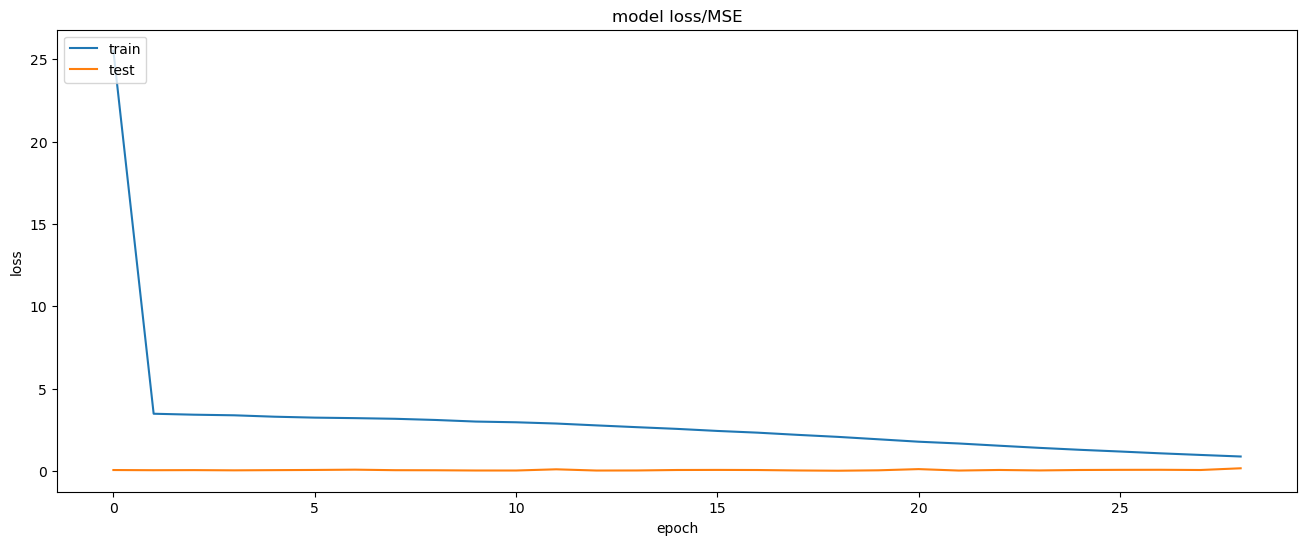

In [56]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model Validation

4696/4696 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
🔹 Model Evaluation on Entire Dataset:
   - Mean Squared Error (MSE): 0.2811
   - Root Mean Squared Error (RMSE): 0.5301
   - Mean Absolute Error (MAE): 0.4029
   - R² Score: -0.0281


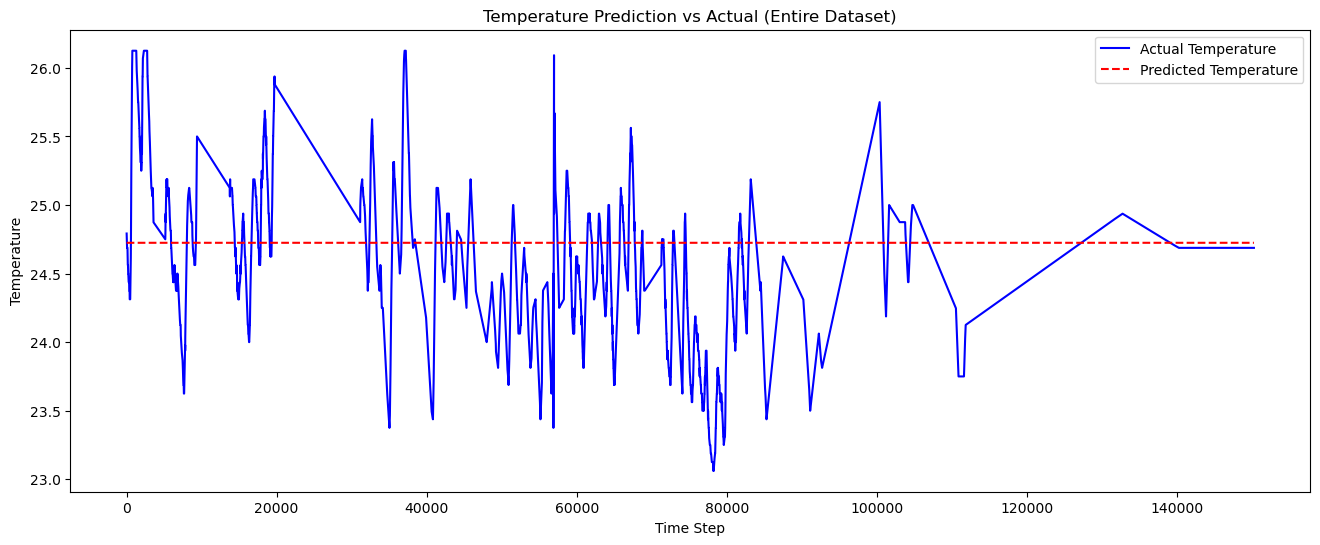

In [99]:
# extract input features and target from the entire dataset
data_values = pond1_fixed[features].values  
target_values = pond1_fixed[target].values  

# create sequences 
seq_arrays, seq_labels = [], []
for i in range(len(data_values) - seq_length - ph): 
    seq = data_values[i : i + seq_length]  
    label = target_values[i + seq_length + ph - 1] 
    seq_arrays.append(seq)
    seq_labels.append(label)

# convert to NumPy arrays
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labels = np.array(seq_labels, dtype=np.float32)

# make predictions
y_pred_full = model.predict(seq_arrays)

# flatten predictions and actual values for comparison
y_pred_full = y_pred_full.flatten()
y_actual_full = seq_labels.flatten()

# get error metrics
mse = mean_squared_error(y_actual_full, y_pred_full)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual_full, y_pred_full)
r2 = r2_score(y_actual_full, y_pred_full)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# plot actual vs. predicted
plt.figure(figsize=(16,6))
plt.plot(y_actual_full, label="Actual Temperature", color='blue')
plt.plot(y_pred_full, label="Predicted Temperature", linestyle="dashed", color='red')
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.title("Temperature Prediction vs Actual (Entire Dataset)")
plt.legend()
plt.show()

#### Model Testing: Unseen data

940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Mean Squared Error (MSE): 0.01229557953774929
Root Mean Squared Error (RMSE): 0.11088543385267258
Mean Absolute Error (MAE): 0.08714384585618973
R-squared Score: -0.0007576483491515962


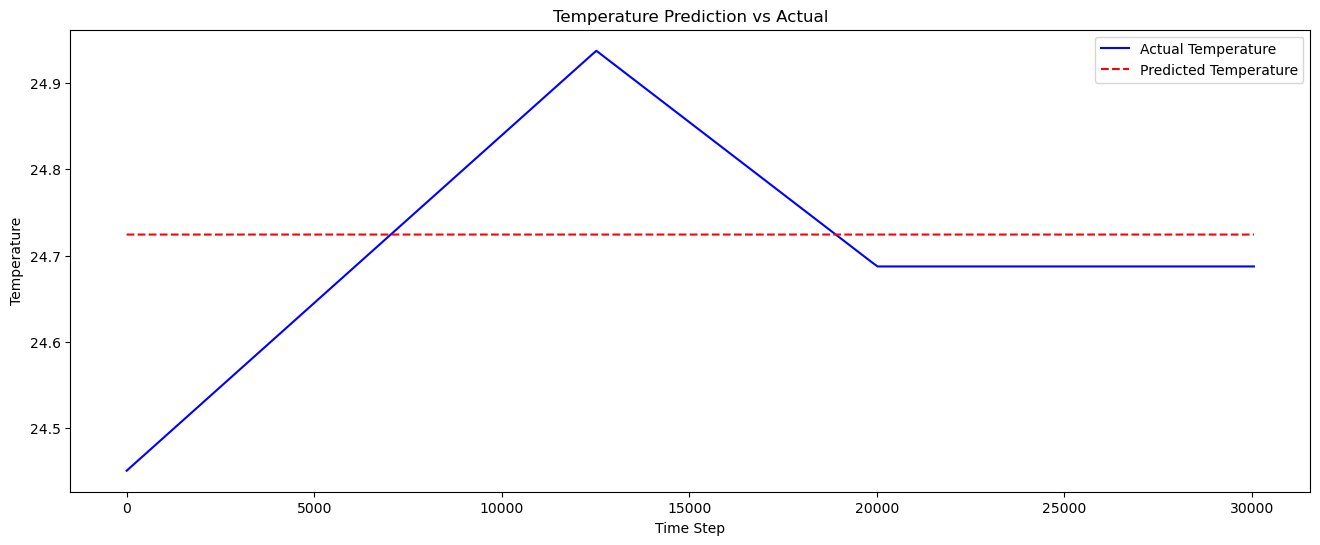

In [58]:
# make predictions on test data
y_pred = model.predict(X_test)

# flatten predictions and actual values for comparison
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# get error metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared Score: {r2}")

# actual vs. predicted 
plt.figure(figsize=(16,6))
plt.plot(y_test, label="Actual Temperature", color='blue')
plt.plot(y_pred, label="Predicted Temperature", linestyle="dashed", color='red')
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.title("Temperature Prediction vs Actual")
plt.legend()
plt.show()

#### Model Deployment

In [61]:
pond1_prediction = pond1_fixed.copy()

# add predictions to existing dataset
pond1_prediction.loc[pond1_prediction.index[-len(y_pred):], 'temperature_predicted'] = y_pred

# predict the next 5 time steps
future_predictions = []
last_seq = X_test[-1]  # get the last sequence from test data

for i in range(5):  # predict 5 future time steps
    next_pred = model.predict(last_seq.reshape(1, seq_length, len(features))).flatten()[0]
    future_predictions.append(next_pred)
    last_seq = np.roll(last_seq, shift=-1, axis=0)  # shift sequence to the left
    last_seq[-1, 0] = next_pred  # replace last time step with predicted temperature (ph and ammonia unchanged)

# create a DataFrame for future predictions
future_timestamps = pd.date_range(start=pond1_fixed['datetime'].max(), periods=6, freq='5T')[1:]  # Next 5 timestamps

future_df = pd.DataFrame({
    'datetime': future_timestamps,
    'temperature_predicted': future_predictions
})

# append future predictions to `pond1_fixed`
pond1_prediction = pd.concat([pond1_fixed, future_df], ignore_index=True)

pond1_prediction.tail(10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,datetime,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight,temperature_predicted
150293,2021-10-01 08:53:05,198744.0,24.6875,100.0,0.126,6.84937,2.77972,1040.0,50.0,31.23,145.3,NaN
150294,2021-10-01 08:54:05,198744.0,24.6875,100.0,0.126,6.84937,2.77972,1040.0,50.0,31.23,145.3,NaN
150295,2021-10-01 08:55:05,198744.0,24.6875,100.0,0.126,6.84937,2.77972,1040.0,50.0,31.23,145.3,NaN
150296,2021-10-01 08:56:05,198744.0,24.6875,100.0,0.126,6.84937,2.77972,1040.0,50.0,31.23,145.3,NaN
150297,2021-10-01 08:57:05,198744.0,24.6875,100.0,0.126,6.84937,2.77972,1040.0,50.0,31.23,145.3,NaN
150298,2021-10-01 09:02:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.724472
150299,2021-10-01 09:07:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.724472
150300,2021-10-01 09:12:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.724472
150301,2021-10-01 09:17:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.724472
150302,2021-10-01 09:22:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.724472


#### Data Export

In [64]:
pond1_fixed.to_csv("pond1_fixed_with_predictions.csv", index=False)
print("✅ Data saved as CSV: pond1_fixed_with_predictions.csv")

✅ Data saved as CSV: pond1_fixed_with_predictions.csv



----------------
$^{1}$ Ogbuokiri, B. (2021). Sensor-based aquaponics fish pond datasets. Kaggle. https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets